In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
#colors!

c_d = '#1b9e77'
c_i = '#d95f02'
c_c = '#7570b3'

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import data

In [105]:
# research article data

domestic_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/domestic_brazil_research.csv')
international_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/international_brazil_research.csv')
collaborative_research = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/collaboration_brazil_research.csv')

domestic_research = domestic_research[domestic_research['Publication Year'] < 2022]
international_research = international_research[international_research['Publication Year'] < 2022]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] < 2022]

domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)


# deforestation data

deforestation_df = pd.read_csv('/content/drive/MyDrive/DSS132_final_project/data/brazil-world-bank-forest-area-percentage.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,20,48,52,58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Pre-processing data

Aligning year ranges between the data

In [106]:
min_year = max([min(domestic_research['Publication Year']), min(international_research['Publication Year']), min(collaborative_research['Publication Year']), min(deforestation_df['year'])])

deforestation_df = deforestation_df[deforestation_df['year']  >= min_year]
domestic_research = domestic_research[domestic_research['Publication Year'] >= min_year]
international_research = international_research[international_research['Publication Year'] >= min_year]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] >= min_year]

deforestation_df = deforestation_df.reset_index(drop=True)
domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)

Dataframes to hold final predictor/response data

In [107]:
len(deforestation_df)

24

In [108]:
domestic_research.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Publication Type', 'Authors',
       'Book Authors', 'Book Editors', 'Book Group Authors',
       'Author Full Names', 'Book Author Full Names', 'Group Authors',
       'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Text',
       'Cited References', 'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', '

In [109]:
len(np.arange(min_year, 2021))

24

In [110]:
domestic_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
international_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
collaborative_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})

Processing article data to get AR index citation metric

In [111]:
def calculate_AR_index(citations, year):
    
    citations = np.array(citations)
    n = citations.shape[0]
    array = np.arange(1, n+1)

    # reverse sorting
    citations = np.sort(citations)[::-1]           

    # computing h-index
    h_idx = np.max(np.minimum(citations, array))
    
    # computing AR index
    paper_age = 2021 - year
    AR = np.sqrt(sum(citations[0:h_idx-1]) / paper_age )
    
    return AR 

In [112]:
def process_article_data(article_df, year_list):
    
    AR_index_list = []
    
    for year in year_list:
        article_df_year = article_df[article_df['Publication Year'] == year]
        AR_index_list.append(calculate_AR_index(article_df_year['Times Cited, All Databases'], year))
        
    return AR_index_list

In [113]:
domestic_df['AR_Index'] = process_article_data(domestic_research, domestic_df['Year'])

international_df['AR_Index'] = process_article_data(international_research, international_df['Year'])

collaborative_df['AR_Index'] = process_article_data(collaborative_research, collaborative_df['Year'])

### Making time-shifted variables

In [114]:
# def get_shift(df, steps_back, min_year):
    
#     df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
#     deforestation_list = np.asarray(df['Deforestation_Rate'])
#     deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
#     df_shifted['Deforestation_Rate'] = deforestation_list
    
#     AR_list = np.asarray(df['AR_Index'])
#     AR_list = AR_list[0:len(AR_list)-steps_back]
#     df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
#     return df_shifted

In [115]:
# domestic_df_list = [domestic_df]
# international_df_list = [international_df]
# collaborative_df_list = [collaborative_df]

# # time shifts of 1-5 years
# for i in range(1, 6):

#     domestic_df_list.append(get_shift(domestic_df, i, min_year)) 
#     international_df_list.append(get_shift(international_df, i, min_year)) 
#     collaborative_df_list.append(get_shift(collaborative_df, i, min_year)) 

In [116]:
def get_forest_loss(df, shift_year, country_area):
    shifted_df = np.asarray(df['Deforestation_Rate'][:-shift_year])
    df_rate = df.loc[shift_year:, :].copy()
    df_rate.loc[:,f'previous_{shift_year}_year_forest_rate'] = shifted_df
    df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year'] = np.abs(df_rate['Deforestation_Rate']*country_area-df_rate[f'previous_{shift_year}_year_forest_rate']*country_area)
    df_rate_clean = pd.DataFrame({'Year':[],'forest_loss_in_km':[], 'AR_Index':[]})
    df_rate_clean['Year'] = df_rate.loc[:,'Year']
    df_rate_clean['forest_loss_in_km'] = df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year']
    df_rate_clean['AR_Index'] = df_rate.loc[:,'AR_Index']
    
    return df_rate_clean
    

In [117]:
brazil_land_area = 8.5*(10**6)

domestic_df_rate = get_forest_loss(domestic_df, 1, brazil_land_area)
international_df_rate = get_forest_loss(international_df, 1, brazil_land_area)
collaborative_df_rate = get_forest_loss(collaborative_df, 1, brazil_land_area)

In [118]:
def get_shift(df, steps_back, min_year):
    
    df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
    deforestation_list = np.asarray(df['forest_loss_in_km'])
    deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
    df_shifted['forest_loss_in_km'] = deforestation_list
    
    AR_list = np.asarray(df['AR_Index'])
    AR_list = AR_list[0:len(AR_list)-steps_back]
    df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
    return df_shifted

In [119]:
international_df_rate['forest_loss_in_km']

1     3845112.700
2     3845112.615
3     3845112.700
4     4017845.450
5     4017845.535
6     4017845.450
7     4017845.450
8     4017845.450
9     4017845.535
10    4017845.450
11    4017845.450
12    4017845.535
13    4017845.450
14    1565303.985
15    1565304.070
16    1565303.985
17    1565303.985
18    1565303.985
19    1833296.660
20    2024284.095
21    1057855.005
22    1274165.045
23    1198909.105
Name: forest_loss_in_km, dtype: float64

In [120]:
international_df_rate.head(2)

Year  forest_loss_in_km  AR_Index
1  1998.0        3845112.700  8.193316
2  1999.0        3845112.615  8.821461

In [121]:
domestic_df_list = [domestic_df_rate]
international_df_list = [international_df_rate]
collaborative_df_list = [collaborative_df_rate]

for i in range(1, 6):

    domestic_df_list.append(get_shift(domestic_df_rate, i, min_year+1)) 
    international_df_list.append(get_shift(international_df_rate, i, min_year+1)) 
    collaborative_df_list.append(get_shift(collaborative_df_rate, i, min_year+1)) 

## Plots of raw data

### Deforestation rate timeseries

In [122]:
domestic_df_rate

Year  forest_loss_in_km   AR_Index
1   1998.0        3845112.700   6.918784
2   1999.0        3845112.615   6.595453
3   2000.0        3845112.700  12.165525
4   2001.0        4017845.450   7.529940
5   2002.0        4017845.535  10.382171
6   2003.0        4017845.450   8.349983
7   2004.0        4017845.450   9.955785
8   2005.0        4017845.450  13.372079
9   2006.0        4017845.535  10.661457
10  2007.0        4017845.450  10.319884
11  2008.0        4017845.450  11.492472
12  2009.0        4017845.535  19.362765
13  2010.0        4017845.450  12.376664
14  2011.0        1565303.985  15.013327
15  2012.0        1565304.070  13.237153
16  2013.0        1565303.985  11.768602
17  2014.0        1565303.985  15.478095
18  2015.0        1565303.985  24.045097
19  2016.0        1833296.660  26.385602
20  2017.0        2024284.095  16.837458
21  2018.0        1057855.005  19.235384
22  2019.0        1274165.045  22.726636
23  2020.0        1198909.105  32.155870

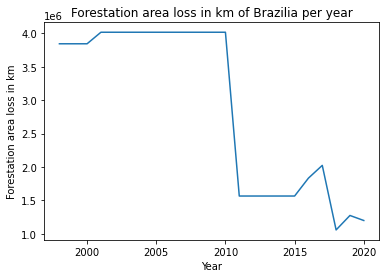

In [123]:
# brazil_land_area = 8.5*(10**6)

# shifted_forest_rate = np.asarray(domestic_df['Deforestation_Rate'][:-1])
# domestic_df_rate = domestic_df[1:]
# domestic_df_rate['previous_year_forest_rate'] = shifted_forest_rate
# domestic_df_rate['forest_loss_in_km'] = np.abs(domestic_df_rate['Deforestation_Rate']*brazil_land_area - 
#                                                 domestic_df_rate['previous_year_forest_rate']*brazil_land_area)


plt.plot(domestic_df_rate['Year'], domestic_df_rate['forest_loss_in_km'])
plt.title(r'Forestation area loss in km of Brazilia per year')
plt.xlabel('Year')
plt.ylabel(r'Forestation area loss in km')
plt.show()

In [124]:
# plt.plot(domestic_df['Year'], domestic_df['Deforestation_Rate'])
# plt.title(r'Forestation area percentage (% of land area) of Brazilia per year')
# plt.xlabel('Year')
# plt.ylabel(r'Forest area percentage (% of land are)')
# plt.show()

### AR index timeseries

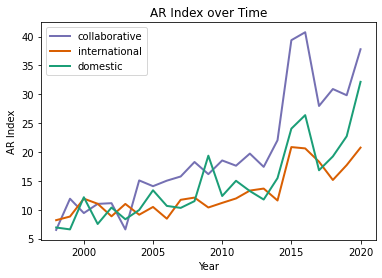

In [125]:
plt.plot(collaborative_df_rate['Year'], collaborative_df_rate['AR_Index'], color=c_c, linewidth=2, label='collaborative')
plt.plot(international_df_rate['Year'], international_df_rate['AR_Index'], color=c_i, linewidth=2, label='international')
plt.plot(domestic_df_rate['Year'], domestic_df_rate['AR_Index'], color=c_d, linewidth=2, label='domestic')
plt.title('AR Index over Time')
plt.xlabel('Year')
plt.ylabel('AR Index')
plt.legend()
         
plt.show()

### Scatter plots of AR Index vs. Deforestation rate

In [126]:
domestic_df_list[0]

Year  forest_loss_in_km   AR_Index
1   1998.0        3845112.700   6.918784
2   1999.0        3845112.615   6.595453
3   2000.0        3845112.700  12.165525
4   2001.0        4017845.450   7.529940
5   2002.0        4017845.535  10.382171
6   2003.0        4017845.450   8.349983
7   2004.0        4017845.450   9.955785
8   2005.0        4017845.450  13.372079
9   2006.0        4017845.535  10.661457
10  2007.0        4017845.450  10.319884
11  2008.0        4017845.450  11.492472
12  2009.0        4017845.535  19.362765
13  2010.0        4017845.450  12.376664
14  2011.0        1565303.985  15.013327
15  2012.0        1565304.070  13.237153
16  2013.0        1565303.985  11.768602
17  2014.0        1565303.985  15.478095
18  2015.0        1565303.985  24.045097
19  2016.0        1833296.660  26.385602
20  2017.0        2024284.095  16.837458
21  2018.0        1057855.005  19.235384
22  2019.0        1274165.045  22.726636
23  2020.0        1198909.105  32.155870

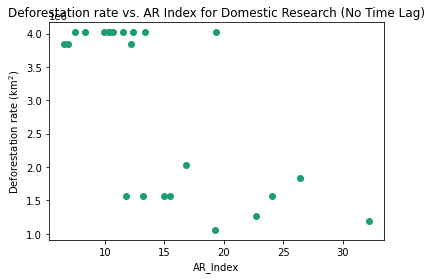

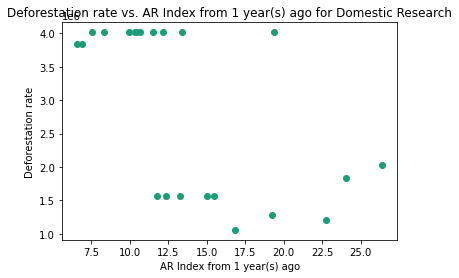

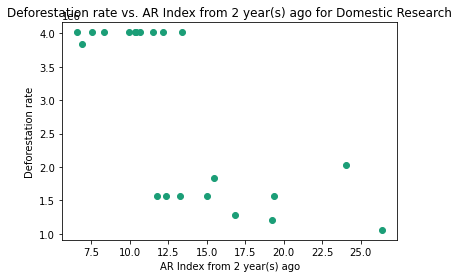

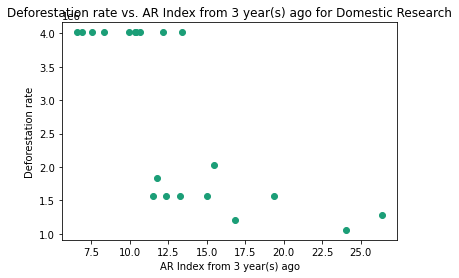

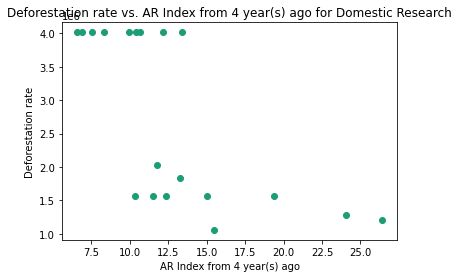

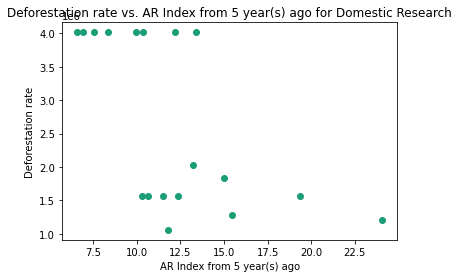

In [127]:
for i in range(0, 6):
    if i==0:
        plt.scatter(domestic_df_list[i]['AR_Index'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

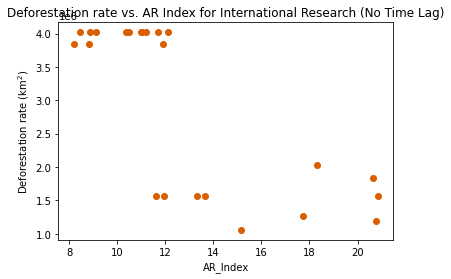

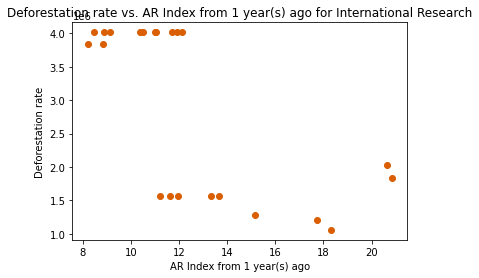

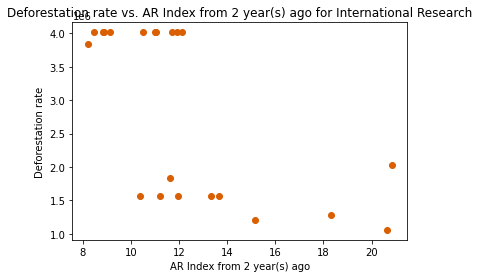

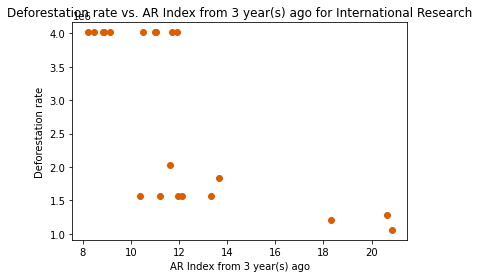

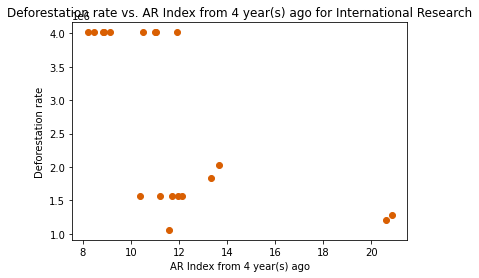

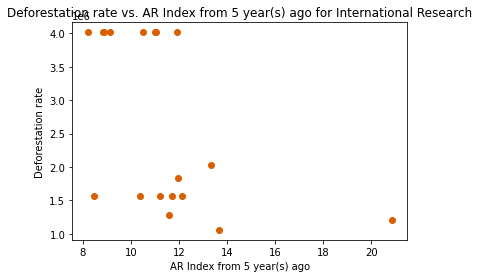

In [128]:
for i in range(0, 6):
    if i==0:
        plt.scatter(international_df_list[i]['AR_Index'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for International Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for International Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

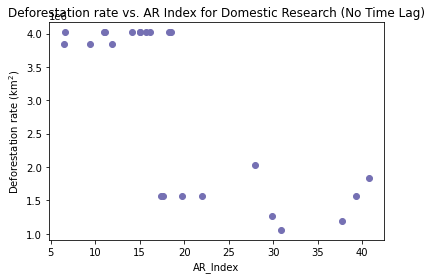

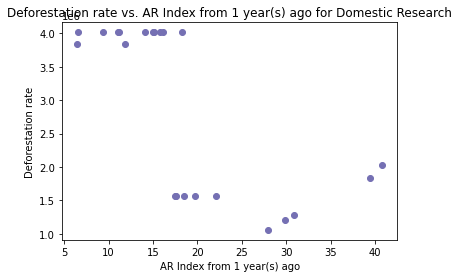

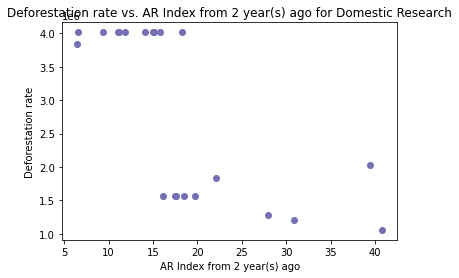

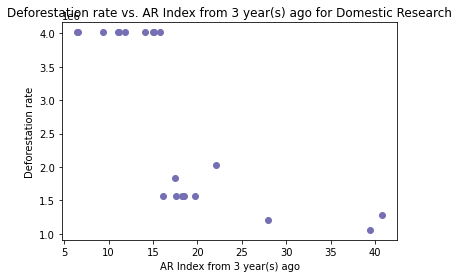

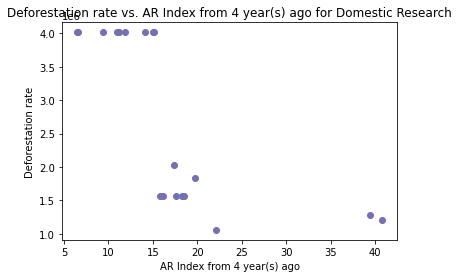

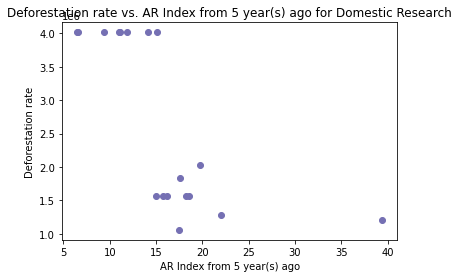

In [129]:
for i in range(0, 6):
    if i==0:
        plt.scatter(collaborative_df_list[i]['AR_Index'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

# Model fitting

In [130]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import patsy as pt

In [131]:
domestic_df_list[1].columns

Index(['Year', 'forest_loss_in_km', 'AR_Index_1_Year_Prev'], dtype='object')

## Linear regression and significance testing

### Domestic

In [132]:
domestic_df_list[-1]

Year  forest_loss_in_km  AR_Index_5_Year_Prev
0   2003.0        4017845.450              6.918784
1   2004.0        4017845.450              6.595453
2   2005.0        4017845.450             12.165525
3   2006.0        4017845.535              7.529940
4   2007.0        4017845.450             10.382171
5   2008.0        4017845.450              8.349983
6   2009.0        4017845.535              9.955785
7   2010.0        4017845.450             13.372079
8   2011.0        1565303.985             10.661457
9   2012.0        1565304.070             10.319884
10  2013.0        1565303.985             11.492472
11  2014.0        1565303.985             19.362765
12  2015.0        1565303.985             12.376664
13  2016.0        1833296.660             15.013327
14  2017.0        2024284.095             13.237153
15  2018.0        1057855.005             11.768602
16  2019.0        1274165.045             15.478095
17  2020.0        1198909.105             24.045097

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     19.69
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000228
Time:                        20:31:14   Log-Likelihood:                -347.59
No. Observations:                  23   AIC:                             699.2
Df Residuals:                      21   BIC:                             701.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.84e+06   4.76e+05     10.169      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


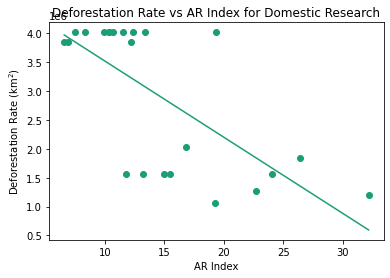

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     11.88
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00255
Time:                        20:31:14   Log-Likelihood:                -334.82
No. Observations:                  22   AIC:                             673.6
Df Residuals:                      20   BIC:                             675.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.801e+06 

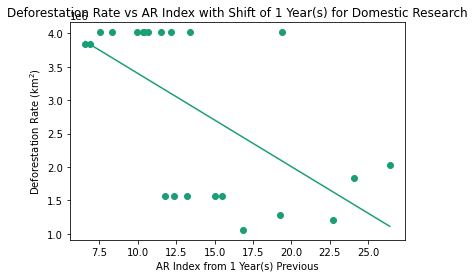

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     22.45
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000143
Time:                        20:31:14   Log-Likelihood:                -316.48
No. Observations:                  21   AIC:                             637.0
Df Residuals:                      19   BIC:                             639.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.204e+06 

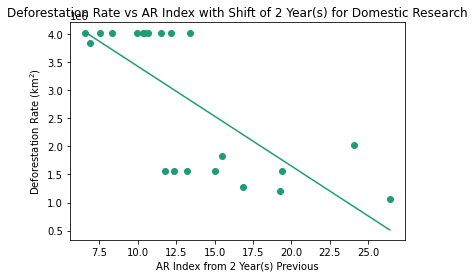

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     21.19
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000221
Time:                        20:31:14   Log-Likelihood:                -301.58
No. Observations:                  20   AIC:                             607.2
Df Residuals:                      18   BIC:                             609.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.136e+06 

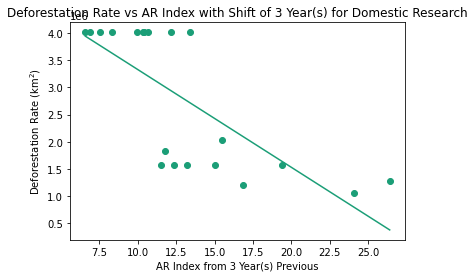

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     14.23
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00152
Time:                        20:31:14   Log-Likelihood:                -288.10
No. Observations:                  19   AIC:                             580.2
Df Residuals:                      17   BIC:                             582.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.817e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


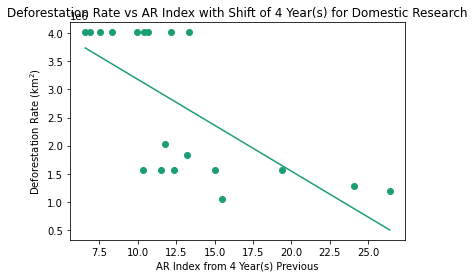

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     9.219
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00786
Time:                        20:31:15   Log-Likelihood:                -274.24
No. Observations:                  18   AIC:                             552.5
Df Residuals:                      16   BIC:                             554.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.812e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


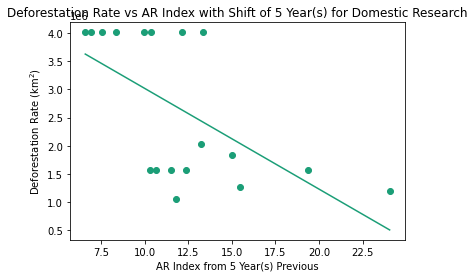

In [133]:
X = domestic_df_list[0]['AR_Index']
y = domestic_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(domestic_df_list[0]['AR_Index'], results.predict(sm.add_constant(domestic_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(domestic_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(domestic_df_list[0]['AR_Index'], y_preds)))
plt.scatter(domestic_df_list[0]['AR_Index'], domestic_df_list[0]['forest_loss_in_km'], color=c_d)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
plt.title(f'Deforestation Rate vs AR Index for Domestic Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = domestic_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = domestic_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for Domestic Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### International

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     27.36
Date:                Wed, 04 May 2022   Prob (F-statistic):           3.48e-05
Time:                        20:31:15   Log-Likelihood:                -345.60
No. Observations:                  23   AIC:                             695.2
Df Residuals:                      21   BIC:                             697.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.937e+06   6.05e+05      9.809      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


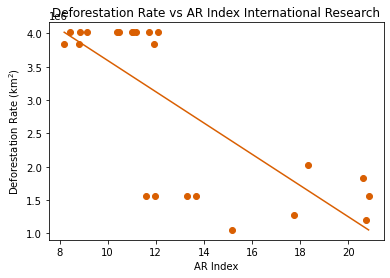

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     17.65
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000440
Time:                        20:31:15   Log-Likelihood:                -332.99
No. Observations:                  22   AIC:                             670.0
Df Residuals:                      20   BIC:                             672.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.785e+06 

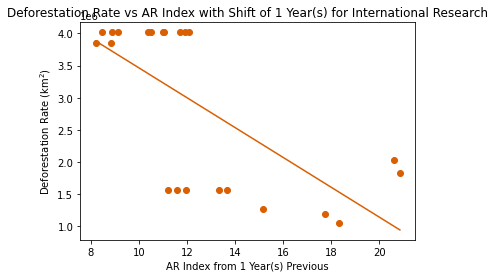

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     13.81
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00146
Time:                        20:31:15   Log-Likelihood:                -318.93
No. Observations:                  21   AIC:                             641.9
Df Residuals:                      19   BIC:                             644.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.627e+06 

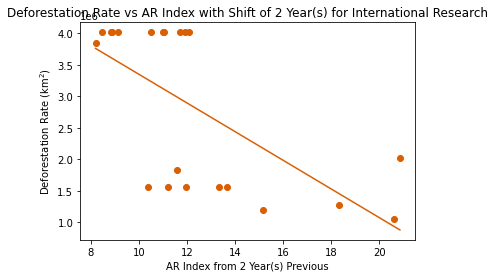

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     17.00
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000639
Time:                        20:31:16   Log-Likelihood:                -302.71
No. Observations:                  20   AIC:                             609.4
Df Residuals:                      18   BIC:                             611.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.746e+06 

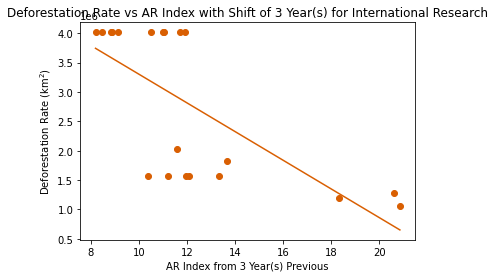

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     10.67
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00455
Time:                        20:31:16   Log-Likelihood:                -289.25
No. Observations:                  19   AIC:                             582.5
Df Residuals:                      17   BIC:                             584.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.436e+06 

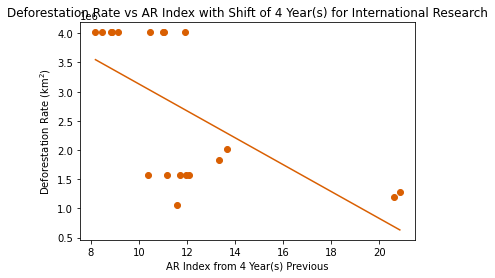

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     5.565
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0314
Time:                        20:31:16   Log-Likelihood:                -275.65
No. Observations:                  18   AIC:                             555.3
Df Residuals:                      16   BIC:                             557.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.246e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


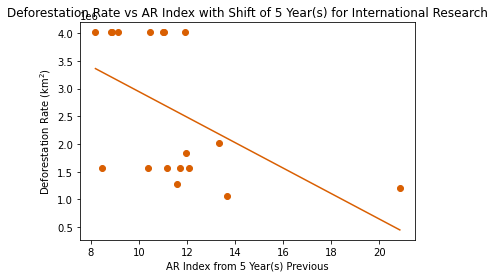

In [134]:
X = international_df_list[0]['AR_Index']
y = international_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(international_df_list[0]['AR_Index'], results.predict(sm.add_constant(international_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(international_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(international_df_list[0]['AR_Index'], y_preds)))
plt.scatter(international_df_list[0]['AR_Index'], international_df_list[0]['forest_loss_in_km'], color=c_i)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
plt.title(f'Deforestation Rate vs AR Index International Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = international_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = international_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(international_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(international_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(international_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(international_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for International Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### Collaborative

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     28.88
Date:                Wed, 04 May 2022   Prob (F-statistic):           2.49e-05
Time:                        20:31:16   Log-Likelihood:                -345.25
No. Observations:                  23   AIC:                             694.5
Df Residuals:                      21   BIC:                             696.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.782e+06    3.9e+05     12.273      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


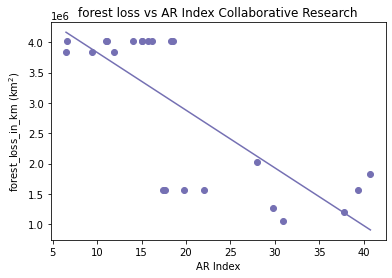

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     19.55
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000263
Time:                        20:31:16   Log-Likelihood:                -332.45
No. Observations:                  22   AIC:                             668.9
Df Residuals:                      20   BIC:                             671.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.645e+06 

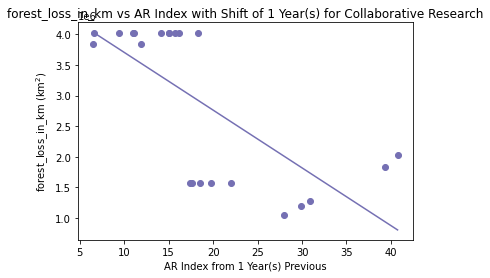

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     18.87
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000350
Time:                        20:31:17   Log-Likelihood:                -317.43
No. Observations:                  21   AIC:                             638.9
Df Residuals:                      19   BIC:                             640.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  4.59e+06 

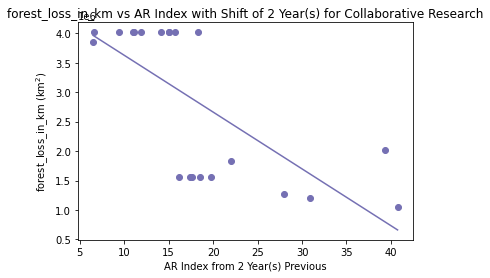

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     22.41
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000166
Time:                        20:31:17   Log-Likelihood:                -301.27
No. Observations:                  20   AIC:                             606.5
Df Residuals:                      18   BIC:                             608.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.632e+06 

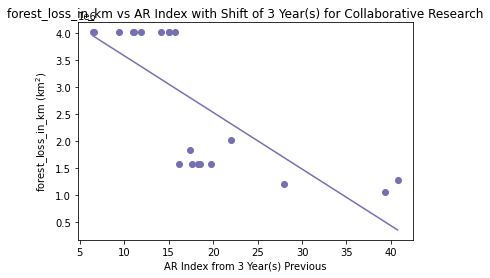

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     16.40
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000833
Time:                        20:31:17   Log-Likelihood:                -287.46
No. Observations:                  19   AIC:                             578.9
Df Residuals:                      17   BIC:                             580.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.419e+06 

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


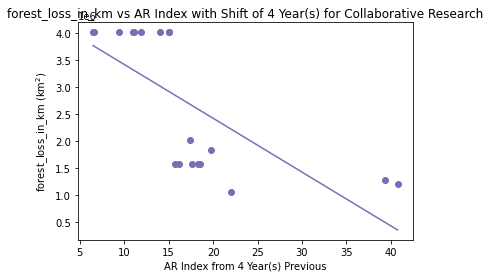

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     14.24
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00166
Time:                        20:31:17   Log-Likelihood:                -272.61
No. Observations:                  18   AIC:                             549.2
Df Residuals:                      16   BIC:                             551.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.561e+06 

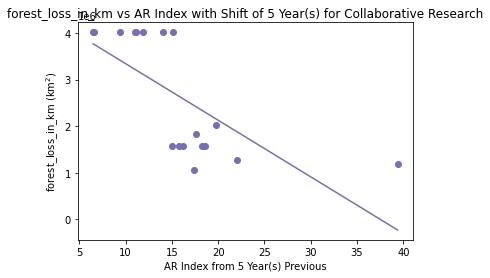

In [135]:
X = collaborative_df_list[0]['AR_Index']
y = collaborative_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(collaborative_df_list[0]['AR_Index'], results.predict(sm.add_constant(collaborative_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(collaborative_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[0]['AR_Index'], y_preds)))
plt.scatter(collaborative_df_list[0]['AR_Index'], collaborative_df_list[0]['forest_loss_in_km'], color=c_c)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
plt.title(f'forest loss vs AR Index Collaborative Research')
plt.xlabel('AR Index')
plt.ylabel(r'forest_loss_in_km (km$^2$)')
plt.show()

for i in range(1,6):
    X = collaborative_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = collaborative_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
    plt.title(f'forest_loss_in_km vs AR Index with Shift of {i} Year(s) for Collaborative Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'forest_loss_in_km (km$^2$)')
    plt.show()

## Polynomial regression and bootstrapping

In [136]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):
    if poly_order == 1:
        X_train_poly = X_train
        X_val_poly = X_val
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_train_poly, y_train)
    
    # Make predictions using the linear regression
    y_pred_poly_val = regr_poly.predict(X_val_poly)
    y_pred_poly_train = regr_poly.predict(X_train_poly)
    
    # Calculate the MSE for both the val and training sets
    MSE_val = mean_squared_error(y_val, y_pred_poly_val)
    MSE_train = mean_squared_error(y_train, y_pred_poly_train)
    
    return MSE_train, MSE_val

In [137]:
def poly_order_cv(X,y,k,poly_order_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]
    
        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1) 
        X_fold_val = np.array(X_fold_val).reshape(-1, 1) 

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        
        for poly_order in range(1,poly_order_max+1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train) 
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    
    # one std error rule
    min_mse_model = mses[mses.mses_ave == min(mses.mses_ave)]
    min_mse_model_folds = min_mse_model.drop(['mses_ave'], axis=1)
    one_std = np.std(min_mse_model_folds.to_numpy())
    upper_range = np.float(min(mses.mses_ave) + one_std)
    order_range = mses[mses.mses_ave < upper_range]
    optimal_order = order_range.index[0] + 1

    
    poly_order_MSE_ave_val_min = optimal_order
    MSE_ave_val_min = mses['mses_ave'].iloc[order_range.index[0]]
    
    return MSE_ave_val_min, poly_order_MSE_ave_val_min

In [138]:
def bootstrap_polynomial_sample_analysis(X,y, poly_order, x_array):
    
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)
    
    X_reshape = np.array(X).reshape(-1, 1)

    # Generate features up to the specified polynomial order 
    if poly_order == 1:
        X_poly = X_reshape
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_poly = poly.fit_transform(X_reshape)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()    
    regr_poly.fit(X_poly, y)
    
    # You do no want to extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the 
    # bootstrap sample, place NaN values. 
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    if poly_order == 1:
        incomes_within_bootstrap_data = incomes_within_bootstrap_data.reshape(-1, 1)
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        incomes_within_bootstrap_data = poly.fit_transform(incomes_within_bootstrap_data.reshape(-1, 1))
    y_pred_within_bootstrap_data_range = regr_poly.predict(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions (below the lowest income in the bootstrap
    # sample, within the income data in the bootstrap sample, and above the highest income in the bootstrap sample)
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

In [139]:
def bootstrap_polynomial_analysis(df, variable_of_interest, response, poly_order_max, k):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df[response]
    y = y.reset_index(drop = True)
    
    x_array = np.linspace(min(X), max(X), 100)
        
    # first determine the best polynomial order using cross-validation
    MSE_ave_val_min, poly_order_MSE_ave_val_min = poly_order_cv(X,y,k,poly_order_max)
    print('The average MSE of the valuation sets:', MSE_ave_val_min)
    print('This occured when using a polynomial of order:', poly_order_MSE_ave_val_min)
    
    # bootstrap analysis given this selected polynomial order
    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap[response]
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_polynomial_sample_analysis(X_bootstrap, y_bootstrap, poly_order_MSE_ave_val_min, x_array)
        y_pred_bootstrap[i] = y_pred
        
    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 50) for i in range(0, len(x_array))]  # median is 50th percentile
    y_pred_bootstrap_summary['95_CI_high'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 97.5) for i in range(0, len(x_array))]
    y_pred_bootstrap_summary['95_CI_low'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 2.5) for i in range(0, len(x_array))]

    
    return y_pred_bootstrap_summary, x_array, MSE_ave_val_min, poly_order_MSE_ave_val_min

In [140]:
def plot_polynomial_bootstrap_analysis(domestic_df, international_df, collaborative_df, variable_of_interest, k):
    
    response = 'forest_loss_in_km'
    poly_order_max = 5
    
    #print('Domestic Research:')
    [y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df, variable_of_interest, response, poly_order_max, k)
    #print('International Research:')
    [y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df, variable_of_interest, response, poly_order_max, k)
    #print('Collaborative Research:')
    [y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df, variable_of_interest, response, poly_order_max, k)
    
    
    plt.scatter(domestic_df[variable_of_interest], domestic_df[response], s=5, color=c_d)
    plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
    plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')
    
    plt.scatter(international_df[variable_of_interest], international_df[response], s=5, color=c_i)
    plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
    plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
   
    plt.scatter(collaborative_df[variable_of_interest], collaborative_df[response], s=5, color=c_c)
    plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
    plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')
   
    plt.xlabel(variable_of_interest)
    plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
    plt.title(f'Deforestation Rate vs. {variable_of_interest}')
    plt.legend()
    plt.show()

In [141]:
def timelag_analysis_polynomial_bootstrap(df_list):
    
    response = 'forest_loss_in_km'
    poly_order_max = 3
    
    MSE_list = []
    optimal_poly_list = []
    
    for i in range(1, 6):
        k = len(df_list[i])
        variable_of_interest = f'AR_Index_{i}_Year_Prev'
        [y_bootstrap_summary, x_array, MSE_min, optimal_poly_order] = bootstrap_polynomial_analysis(df_list[i], variable_of_interest, response, poly_order_max, k)
        MSE_list.append(MSE_min)
        optimal_poly_list.append(optimal_poly_order)
        
    timelag_analysis_df = pd.DataFrame({'Lag': np.arange(1, 6), 'MSE': MSE_list, 'optimal poly order': optimal_poly_list})    
    
    return timelag_analysis_df

In [142]:
def print_timelag_analysis(timelag_analysis_df):
    
    best_row = timelag_analysis_df.iloc[timelag_analysis_df['MSE'].idxmin()]
    min_MSE = best_row['MSE']
    best_poly = best_row['optimal poly order']
    optimal_lag = best_row['Lag']
    
    print(f'Optimal lag: {optimal_lag}')
    print(f'Occured with polynomial order {best_poly}')
    
    return min_MSE, best_poly, optimal_lag

### Timelag analysis

In [143]:
print('-----------Domestic Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(domestic_df_list))
print('-----------International Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(international_df_list))
print('-----------Collaborative Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(collaborative_df_list))

-----------Domestic Research---------------
The average MSE of the valuation sets: 1139078183997.6218
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 861724721860.5198
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 886780380065.0726
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1034753982546.677
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1223149648958.747
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 2.0
Occured with polynomial order 1.0
-----------International Research---------------
The average MSE of the valuation sets: 982362226774.8718
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 1086810015139.0471
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 948960840031.9281
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1170055682933.93
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1687012485346.2327
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 3.0
Occured with polynomial order 1.0
-----------Collaborative Research---------------
The average MSE of the valuation sets: 963642966588.5875
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

The average MSE of the valuation sets: 955576546824.8497
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 879186829008.2976
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1037143268193.5648
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1835475105918.1782
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Optimal lag: 3.0
Occured with polynomial order 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

(879186829008.2976, 1.0, 3.0)

### Plots for optimal lag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 861724721860.5198
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 955576546824.8497
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

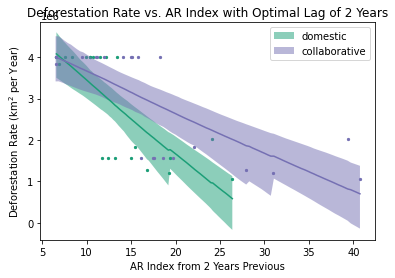

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 1687012485346.2327
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

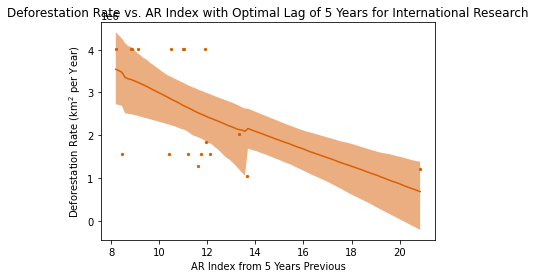

In [144]:
response = 'forest_loss_in_km'
poly_order_max = 5


variable_of_interest = 'AR_Index_2_Year_Prev'

[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[2], variable_of_interest, response, poly_order_max, len(domestic_df_list[2]))

plt.scatter(domestic_df_list[2][variable_of_interest], domestic_df_list[2][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[2], variable_of_interest, response, poly_order_max, len(collaborative_df_list[2]))
plt.scatter(collaborative_df_list[2][variable_of_interest], collaborative_df_list[2][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

plt.xlabel('AR Index from 2 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 2 Years')
plt.legend()
plt.show()



variable_of_interest = 'AR_Index_5_Year_Prev'

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 5 Years for International Research')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The average MSE of the valuation sets: 1223149648958.747
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1835475105918.1782
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

The average MSE of the valuation sets: 1687012485346.2327
This occured when using a polynomial of order: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

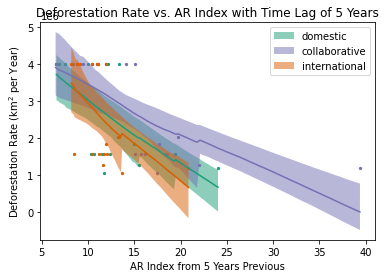

In [145]:
variable_of_interest = 'AR_Index_5_Year_Prev'


[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[5], variable_of_interest, response, poly_order_max, len(domestic_df_list[5]))

plt.scatter(domestic_df_list[5][variable_of_interest], domestic_df_list[5][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[5], variable_of_interest, response, poly_order_max, len(collaborative_df_list[5]))
plt.scatter(collaborative_df_list[5][variable_of_interest], collaborative_df_list[5][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')

plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Time Lag of 5 Years')
plt.legend()
plt.show()